This Jupyter notebook is code belonging to Arnav Gupta regarding his internship at Tech Mahindra. 

The project is about Semi-Conductor Wafer Construction Optimization. We are trying to identify which wafers are able to be sold to consumers and if they're not, what their failure is. 

**Import and start sorting data**

In [1]:
import pickle
import pandas as pd
import numpy as np

wafer_data = pd.read_pickle("LSWMD.pkl")

In [2]:
wafer_data = wafer_data.drop(['waferIndex'], axis = 1)

In [3]:
noType = wafer_data[wafer_data.failureType.str.len() == 0]
noneType = wafer_data[wafer_data.failureType == 'none']
wafer_data = wafer_data[wafer_data.failureType.str.len() > 0]
hasType = wafer_data[wafer_data.failureType != 'none']

/Users/ajaigupta/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1603: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


**Import important libraries**

In [4]:
import tensorflow as tf
tf.version
import matplotlib.pyplot as plt
%matplotlib inline

**Sort the data to only get a specific size and shape to pass into model and also split into training and test data**

*This is before resizing and scaling the data so all of it can be used.*

In [6]:
hasType = hasType.reset_index(drop = True)
currLen_train = []
currLen_test = []
y_train = []
y_test = []
l = 0
for i in range(len(hasType)):
    if(len(hasType.waferMap[i]) == 26 and hasType.trianTestLabel[i] == 'Training' and len(hasType.waferMap[i][0]) == 26):
        currLen_test.append(hasType.waferMap[i][:])
        #y_test.append(hasType.failureType[i][:])
    elif(len(hasType.waferMap[i]) == 26 and hasType.trianTestLabel[i] == 'Test' and len(hasType.waferMap[i][0]) == 26):
        currLen_train.append(hasType.waferMap[i][:])
       # y_train.append(hasType.failureType[i][:])

**Test out PIL library and resize random images to get an idea of how the library works**

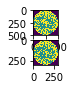

In [8]:
from PIL import Image
from numpy import array
hasType = hasType.reset_index(drop = True)
img = Image.fromarray(currLen_test[9])
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(2, 1))
#ax[0].imshow(img)
wpercent = (300/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
newimg = img.resize((500,500), Image.ANTIALIAS)
newimg2 = img.resize((300,300))
ax[0].imshow(newimg)
ax[1].imshow(newimg2)

**Resize all of the data to 75x75 and split into training and test data**

In [13]:
hasType = hasType.reset_index(drop = True)
scaledimgs = [0]
scaledtrain = [0]
scaledtest = [0]

traincount = 0
testcount = 0
for y in range(len(hasType)):
    img = Image.fromarray(hasType.waferMap[y])
    scimg = img.resize((75, 75), Image.ANTIALIAS)
    arrayscimg = array(scimg)
    scaledimgs.append(arrayscimg)

scaledimgs = np.asarray(scaledimgs)

y = 0
scaledtrain.pop(0)
for y in range(len(hasType)):
    if(hasType.trianTestLabel[y] == 'Training'):
        if(type(scaledimgs[y]) is not int):
            scaledtrain.append(scaledimgs[y])
        traincount += 1
        y_train.append(hasType.failureType[y][:])
    elif(hasType.trianTestLabel[y] == 'Test'):
        scaledtest.append(scaledimgs[y])
        testcount += 1
        y_test.append(hasType.failureType[y][:])

**Convert lists into arrays and get rid of empty data**

In [14]:
scaledtest.pop(0)
scaledtrain.pop(0)
scaledtrain.pop(1)
sctrainarray = np.asarray(scaledtrain)
sctestarray = np.asarray(scaledtest)
sctrainarray = np.delete(sctrainarray, 0, 0)

In [15]:
sctestarray.shape

(7894, 75, 75)

In [16]:
sctestarray = sctestarray.reshape([7894, 75, 75, 1])

**Create Convolutional Neural Network to classify each of the images**

In [17]:
from tensorflow import keras
model = keras.Sequential([
    keras.layers.Conv2D(32, input_shape = (75, 75, 1), kernel_size = (2, 2), strides = (2,2), activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    keras.layers.Conv2D(64, kernel_size = (2, 2), strides = (2,2), activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    keras.layers.Conv2D(128, kernel_size = (2, 2), strides = (2,2), activation = "relu"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(440575, activation='relu'),
    keras.layers.Dense(8, activation='softmax')
])

In [18]:
from keras import optimizers
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

Using TensorFlow backend.


In [19]:
fy_train = np.vstack(y_train)
fy_test = np.vstack(y_test)

**One hot encode y arrays to be able to classify the images**

*Models can't sort to strings, only arrays and integers*

In [20]:
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
ytrain_encoded = label_encoder.fit_transform(fy_train)
test_encoded = label_encoder.fit_transform(fy_test)
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

/Users/ajaigupta/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Train model!!**

In [21]:
model.fit(sctestarray, test_encoded, epochs=50, shuffle = True, batch_size = 1000)

W0823 16:07:40.258959 4523095488 deprecation.py:323] From /Users/ajaigupta/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7894 samples
Epoch 1/50
7894/7894 [==============================] - 49s 6ms/sample - loss: 1.9128 - accuracy: 0.2474
Epoch 2/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.7120 - accuracy: 0.3354
Epoch 3/50
7894/7894 [==============================] - 46s 6ms/sample - loss: 1.6934 - accuracy: 0.3512
Epoch 4/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.6811 - accuracy: 0.3512
Epoch 5/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.6736 - accuracy: 0.3512
Epoch 6/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.6419 - accuracy: 0.3581
Epoch 7/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.5591 - accuracy: 0.4054
Epoch 8/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.5062 - accuracy: 0.4204
Epoch 9/50
7894/7894 [==============================] - 47s 6ms/sample - loss: 1.4609 - accuracy: 0.4473
Epoch 10/50
7894/7894 [==========

**Save model to local machine and convert to TFLite**

In [22]:
keras_file = "wafermodel"
saved_model = tf.compat.v2.keras.models.save_model(model, keras_file)

In [23]:
def representative_dataset_gen():
    for _ in range(len(sctestarray)):
    # Get sample input data as a numpy array in a method of your choosing.
        yield [input]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
tflite_quant_model = converter.convert()

ValueError: Cannot set tensor: Got tensor of type STRING but expected type FLOAT32 for input 1, name: conv2d_input 

In [ ]:
preds = model.predict(acurrLen_test)

In [ ]:
for g in range(len(sctrainarray)):
    sctrainarray[g].reshape([75, 75, 1])
    print(sctrainarray[g].shape)

In [ ]:
count = 0
newarray = []
for b in range(len(sctrainarray)):
    if(sctrainarray[b].shape == (75,75)):
        newarray.append(sctrainarray[b])
        count += 1
    
print(count)

In [ ]:
sctestarray[0].dtype

In [ ]:
sctestarray.dtype

In [ ]:
saved_model.dtype

In [ ]:
tf.version